In [22]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import glob, os
import pylab
import sklearn
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
import timeit
%matplotlib inline

In [23]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Select sample

In [ ]:
store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1203.h5')
data1 = store['APCdata']
store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1206.h5')
data2 = store['APCdata']
store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1209.h5')
data3 = store['APCdata']

In [ ]:
def day_sample(data, month, start_date, end_date):
    month = data.loc[data['mo'] == month]
    day_sample = month[(month['day'] >= start_date) & (month['day'] <= end_date)]
    return day_sample

In [ ]:
Apr_sample = day_sample(data1, 4, 24, 26)
May_sample = day_sample(data1, 5, 2, 4)

In [ ]:
Sep_sample1 = day_sample(data2, 9, 18, 20)
Sep_sample2 = day_sample(data2, 9, 25, 27) 
Oct_sample1 = day_sample(data3, 10, 2, 4)
Oct_sample2 = day_sample(data3, 10, 9, 11)
Oct_sample3 = day_sample(data3, 10, 16, 18)
Oct_sample4 = day_sample(data3, 10, 23, 25)

In [ ]:
Spring_Fall_Sample = pd.concat([Apr_sample, May_sample, Sep_sample1, Sep_sample2, Oct_sample1, Oct_sample2, Oct_sample3, Oct_sample4], ignore_index=True)

In [ ]:
Spring_Fall_Sample.to_csv('R:/Angela/fast_trips/SampleDataSpringFall.csv')

In [26]:
#Spring_Fall_Sample.to_csv('R:/Angela/fast_trips/SampleDataSpringFall.csv')
Spring_Fall_Sample = pd.read_csv('R:/Angela/fast_trips/SampleDataSpringFall.csv')
test = Spring_Fall_Sample 
print 'finished sampling'

finished sampling


#Prepare bus info

In [27]:
vehicles = pd.read_csv(r'R:\Angela\fast_trips\Vehicles.csv')
fleet = pd.read_csv(r'R:\Angela\fast_trips\Copy of Fleet.csv')
vehicles.Artic = vehicles.Length.map({60 : 1, 40 : 0, 30 : 0})
vehicles.Floor = vehicles['Low Floor'].map({'Y': 1, 'N' : 0})
vehicles.loc[:,'Artic'] = pd.Series(vehicles.Artic, index=vehicles.index)
vehicles.loc[:,'Floor'] = pd.Series(vehicles.Floor, index=vehicles.index)
df_artic = vehicles.set_index('Equip_Type').to_dict()['Artic']
df_floor = vehicles.set_index('Equip_Type').to_dict()['Floor']
df_doors = vehicles.set_index('Equip_Type').to_dict()['Doors']
fleet['Doors'] = fleet['Equip_Type'].map(df_doors)
fleet['Artic'] = fleet['Equip_Type'].map(df_artic)
fleet['Floor'] = fleet['Equip_Type'].map(df_floor)
df_vehnum_doors = fleet.set_index('VehNum').to_dict()['Doors']
df_vehnum_artic = fleet.set_index('VehNum').to_dict()['Artic']
df_vehnum_floor = fleet.set_index('VehNum').to_dict()['Floor']

# Prepare route type

In [7]:
route_type = pd.read_csv(r'R:\Angela\fast_trips\MuniRouteTypes.csv')
route_type = route_type.dropna()
dict_route_type = {}
dict_route_type = route_type.set_index('APC Route ID')['Type'].to_dict()

#Step1: Prepare basic variables

In [30]:
def get_x_y(data):
    start = timeit.default_timer()
    #Get rid of rows where certain fields has null/nan values
    data = data.dropna(subset = ['on', 'off', 'vehno'])
    #input bus type info into raw data
    #COMPUTE EOL = RINDEX(ANAME,' - EOL') 
    data['EOL']= data.apply(lambda x: '- EOL' in x['stop_name'], axis=1).map({False: 1, True: 0})
    #remove the last stop
    data = data.loc[data['EOL'] == 1]
    #remove the first stop
    data = data.loc[data['stop_sequence'] != 1]
    stop = timeit.default_timer()
    print 'clean data:', stop - start

    #COMPUTE TIMESTOP=((HR * 3600) + (MIN * 60) + SEC)
    start = timeit.default_timer()
    data['COMPUTE_TIMESTOP'] = data['arr_hour']*3600 + data['arr_min']*60 + data['arr_sec']
    #COMPUTE DOORCLOSE=(( DHR * 3600) + (DMIN * 60) + DSEC)
    data['COMPUTE_DOORCOLSE'] = data['dep_hr']*3600 + data['dep_min']*60 + data['dep_sec']
    #COMPUTE DOORDWELL=DOORCLOSE - TIMESTOP
    data['COMPUTE_DOORDWELL'] = data['COMPUTE_DOORCOLSE'] - data['COMPUTE_TIMESTOP']
    #appling door dwell time less than 120 secs
    data = data.loc[data['COMPUTE_DOORDWELL'] <= 120]
    stop = timeit.default_timer()
    print 'compute dwell time:', stop - start

    #Keep rows that satisfy a query:
    start = timeit.default_timer()
    data['Doors'] = data['vehno'].map(df_vehnum_doors) 
    data['Artic'] = data['vehno'].map(df_vehnum_artic)
    data['Floor'] = data['vehno'].map(df_vehnum_floor)
    data['two_doors'] = data['Doors'].map({2: 1, 3: 0})
    data['three_doors'] = data['Doors'].map({2: 0, 3: 1})
    data['all_door_boarding']= data.apply(lambda x: x['mo'] > 6, axis=1).map({False: 0, True: 1})
    #Create dummie variables for route id
    data['Route Type'] = data['route'].map(dict_route_type)
    just_dummies_route = pd.get_dummies(data['Route Type'])
    step_1 = pd.concat([data, just_dummies_route], axis=1)
    step_1.drop(['Local'], inplace=True, axis=1)
    data = step_1
    stop = timeit.default_timer()
    print 'add veh&route info:', stop - start

    #Create interaction variables
    start = timeit.default_timer()
    data['on_threedoors'] = data['on']*data['three_doors']
    data['off_threedoors'] = data['off']*data['three_doors']
    data['on_floor'] = data['on']*data['Floor']
    data['off_floor'] = data['off']*data['Floor']
    data['floor_threedoors'] = data['Floor']*data['three_doors']
    data['floor_twodoors'] = data['Floor']*data['two_doors']
    data['on_all_door_boarding'] = data['on']*data['all_door_boarding']
    data['off_all_door_boarding'] = data['off']*data['all_door_boarding']
    data['on_express'] = data['on']*data['Express']
    data['off_express'] = data['off']*data['Express']
    data['on_rapid'] = data['on']*data['Rapid']
    data['off_rapid'] = data['off']*data['Rapid']
    data['on_owl'] = data['on']*data['OWL']
    data['off_owl'] = data['off']*data['OWL']
    stop = timeit.default_timer()
    print 'add interaction variables:', stop - start

    return data

# Step2: Prepare vehicle ID variables

In [31]:
#Create dummie variables for bus id 
def create_vehID(data):
    start = timeit.default_timer()
    just_dummies_veh = pd.get_dummies(data['vehno'])
    data = pd.concat([data, just_dummies_veh], axis=1)
    #get rid of one dummy variable to avoid the dummy variable trap
    #step_1.drop([8515], inplace=True, axis=1)
    stop = timeit.default_timer()
    print 'add bus id variables:', stop - start
    return data

# Step3: Delete a vehicle variable in each route type

In [32]:
#to check whether vehcle:8515 is in the sample, if it is not, we should pick up another veh id to delete
#for every route type, get rid of one dummy bus id variable, to avoid the dummy variable trap
#step1 = data.drop([owl_veh], inplace=True, axis=1)
def del_vehID(data):
    express = data.loc[data['Express'] == 1]
    express_veh = np.unique(express['vehno'])[1]
    print express_veh
    rapid = data.loc[data['Rapid'] == 1]
    rapid_veh = np.unique(rapid['vehno'])[1]
    print rapid_veh
    owl = data.loc[data['OWL'] == 1]
    owl_veh = np.unique(owl['vehno'])[1]
    print owl_veh
    print data.shape
    data = data.drop([express_veh, rapid_veh, owl_veh], 1)
    print data.shape
    
    return data

In [33]:
step1 = get_x_y(test)

clean data: 30.4064885698
compute dwell time: 4.7876152221
add veh&route info: 31.7353217374
add interaction variables: 0.179709198244


In [34]:
step2 = create_vehID(step1)

add bus id variables: 17.54275258


In [35]:
step3 = del_vehID(step2)
print 'finished data preparation'

2802
6200
6223
(2255600, 282)
(2255600, 279)
finished data preparation


In [87]:
data = step3.drop(['Unnamed: 0'], axis = 1)
print data.columns

Index([           u'on',           u'off',         u'vehno',         u'route',
           u'stop_name', u'stop_sequence',            u'mo',           u'day',
                  u'yr',      u'arr_hour',
       ...
                   8451,             8503,             8504,             8505,
                   8506,             8507,             8508,             8511,
                   8515,             8520],
      dtype='object', length=278)


# Build multi-linear regression model

# Model - with vehicle ids

In [129]:
#Run Linear Regression In Python SciKit-Learn
start = timeit.default_timer()
X = data.drop(['COMPUTE_DOORDWELL','vehno','stop_name', 'stop_sequence', 'arr_hour','arr_min',
               'arr_sec','route','mo','yr','dep_hr','dep_min','dep_sec', 'EOL',
               'COMPUTE_TIMESTOP','COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors',
               'two_doors', 'Artic', 'Route Type', 'floor_threedoors', 
               'floor_twodoors'], axis=1)
# impute missing values
X[np.isnan(X)] = np.median(X[~np.isnan(X)])
y = data.COMPUTE_DOORDWELL
print len(X)
print len(y)
stop = timeit.default_timer()
print 'prepare x,y for regression:', stop - start

2255600
2255600
prepare x,y for regression: 29.6286718862


In [130]:
#train 70% data
#validate 30% data
length = len(X) * 0.3
length_index = (-1) * int(length)
X_train = X[:length_index]
X_test = X[length_index:]
y_train = y[:length_index]
y_test = y[length_index:]
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(1578920, 256)
(676680, 256)
(1578920L,)
(676680L,)


In [131]:
start = timeit.default_timer()
lm1 = LinearRegression()
lm1.fit(X, y)
pred_train = lm1.predict(X)
pred_test = lm1.predict(X_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

#construct a data frame that contains features and estimated coefficients
sklearn_results = pd.DataFrame(zip(X_train.columns, lm1.coef_), columns = ['features', 'estimatedCoefficients'])
#p-values
scores, pvalues = chi2(X_train, y_train)
sklearn_results['pvalues'] = pd.DataFrame(pvalues)
sklearn_results['scores'] = pd.DataFrame(scores)
stop = timeit.default_timer()
print 'build model with veh ids:', stop - start

build model with veh ids: 41.7650343014


In [ ]:
sklearn_results.to_csv('R:/Angela/fast_trips/muni_apc_2012/SpringFall2012_datasets_withVeh.csv')

In [133]:
print sklearn_results

                  features  estimatedCoefficients  pvalues      scores
0                       on                  2.560    0.000 3134404.960
1                      off                  1.540    0.000 2061857.223
2                      day                  0.000    0.000    4135.556
3                    Floor        20961093259.685    0.000   28726.203
4              three_doors                  7.222    0.000   24528.652
5        all_door_boarding                 -0.519    0.000     241.803
6                  Express                  1.158    0.000   11040.316
7                      OWL                 -0.892    0.000    1076.885
8                    Rapid                  4.756    0.000   32981.092
9            on_threedoors                 -0.055    0.000 1300769.628
10          off_threedoors                 -0.201    0.000  834332.514
11                on_floor                  0.661    0.000  150569.718
12               off_floor                  0.457    0.000  113882.232
13    

# Plots

In [134]:
#pre-check whether there is any negative value in (y_train)
c = 0
for ele in y_train:
    if ele < 0:
        print ele
        c += 1
if c == 0:
    print 'there is no nagative value in y_tain'

there is no nagative value in y_tain


In [135]:
#pre-check whether there is any megative value in lm.predict(X_train)
neg_dict = {}
j = 0
for ele in range(1, len(X_train)):
    i = ele-1
    #print i
    if lm1.predict(X_train[i:ele])<0: 
        neg_dict[ele] = lm1.predict(X_train[i:ele])
        j += 1
print j

6369


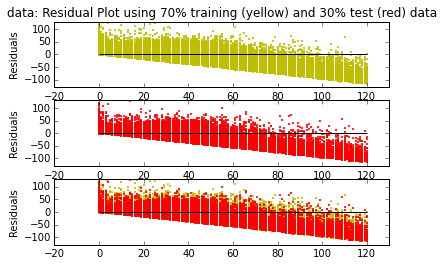

In [136]:
plt.figure(1)

plt.subplot(311)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('Residuals')

plt.subplot(312)
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('Residuals')

plt.subplot(313)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1, edgecolor='y')
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1, edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('Residuals')
plt.show()

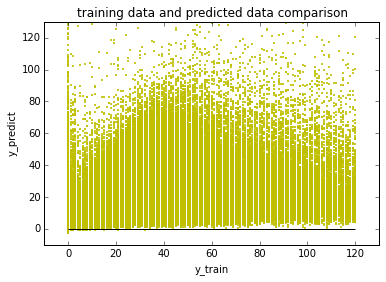

In [138]:
plt.figure(1)

plt.scatter(y_train, lm1.predict(X_train), c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -10, 130])
plt.title('training data and predicted data comparison')
plt.ylabel('y_predict')
plt.xlabel('y_train')
plt.show()

# Model - without vehicle IDs

In [164]:
X2_train = X_train[['on','off','Floor','three_doors','all_door_boarding','Express','OWL','Rapid','on_threedoors','off_threedoors',
            'on_floor','off_floor','on_all_door_boarding','off_all_door_boarding','on_express',
            'off_express','on_rapid','off_rapid','on_owl','off_owl']]
y2_train = y_train
X2_test = X_test[['on','off','Floor','three_doors','all_door_boarding','Express','OWL','Rapid','on_threedoors','off_threedoors',
            'on_floor','off_floor','on_all_door_boarding','off_all_door_boarding','on_express',
            'off_express','on_rapid','off_rapid','on_owl','off_owl']]
y2_test = y_test
print 'done'

done


In [165]:
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

#construct a data frame that contains features and estimated coefficients
sklearn_results2 = pd.DataFrame(zip(X2_train.columns, lm2.coef_), columns = ['features', 'estimatedCoefficients'])
#p-values
scores, pvalues = chi2(X2_train, y2_train)
sklearn_results2['pvalues'] = pd.DataFrame(pvalues)
sklearn_results2['scores'] = pd.DataFrame(scores)
stop = timeit.default_timer()
print 'build model without veh ids:', stop - start

build model without veh ids: 1505.23331455


In [ ]:
sklearn_results2.to_csv('R:/Angela/fast_trips/muni_apc_2012/SpringFall2012_datasets_withoutVeh.csv')

In [166]:
print sklearn_results2

                 features  estimatedCoefficients  pvalues      scores
0                      on                  2.552    0.000 3134404.960
1                     off                  1.522    0.000 2061857.223
2                   Floor                 -2.453    0.000   28726.203
3             three_doors                  0.890    0.000   24528.652
4       all_door_boarding                 -0.495    0.000     241.803
5                 Express                  1.124    0.000   11040.316
6                     OWL                 -1.195    0.000    1076.885
7                   Rapid                  4.684    0.000   32981.092
8           on_threedoors                  0.006    0.000 1300769.628
9          off_threedoors                 -0.108    0.000  834332.514
10               on_floor                  0.663    0.000  150569.718
11              off_floor                  0.540    0.000  113882.232
12   on_all_door_boarding                  0.000    0.000 1915734.205
13  off_all_door_boa

# Plots

done
done
done


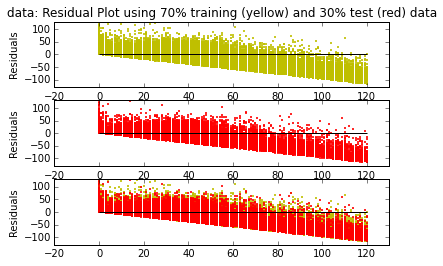

In [168]:
plt.figure(1)
plt.subplot(311)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('Residuals')
print 'done'
plt.subplot(312)
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('Residuals')
print 'done'
plt.subplot(313)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1, edgecolor='y')
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1, edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('Residuals')
print 'done'
plt.show()

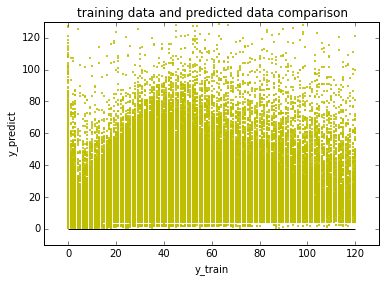

In [169]:
plt.figure(1)

plt.scatter(y2_train, lm2.predict(X2_train), c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -10, 130])
plt.title('training data and predicted data comparison')
plt.ylabel('y_predict')
plt.xlabel('y_train')
plt.show()